# DAT341 Applied Machine Learning

## Programming Assignment 5: Dermatological Image Classification

In [7]:
import torch
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision.models import ResNet18_Weights

Choose the measure device. Define Data Preprocessing (Data Augmentation and Standard Preprocessing)

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_transform_aug = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.5, 1.0)),  
    transforms.RandomHorizontalFlip(), 
    transforms.RandomRotation(10),  
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),  
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
])

train_transform_no_aug = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
])

val_transform = transforms.Compose([
    transforms.Resize(256),  
    transforms.CenterCrop(224),  
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
])

train_data_aug = datasets.ImageFolder('a5_data/train', transform=train_transform_aug)
train_data_no_aug = datasets.ImageFolder('a5_data/train', transform=train_transform_no_aug)
val_data = datasets.ImageFolder('a5_data/val', transform=val_transform)
test_data = datasets.ImageFolder('a5_data/test', transform=val_transform)

train_loader_aug = DataLoader(train_data_aug, batch_size=32, shuffle=True)
train_loader_no_aug = DataLoader(train_data_no_aug, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

Define SimpleCNN

In [9]:
class SimpleCNN(nn.Module):
    def __init__(self, use_bn=False, use_residual=False):
        super(SimpleCNN, self).__init__()
        self.use_residual = use_residual
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64) if use_bn else nn.Identity()
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(128) if use_bn else nn.Identity()
        self.fc = None 
        if use_residual:
            self.residual_conv = nn.Conv2d(3, 128, kernel_size=1, stride=2)

    def forward(self, x):
        residual = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool(x)  
        x = self.conv2(x)
        x = self.bn2(x)
        if self.use_residual:
            residual = self.residual_conv(residual)  
            x += residual
        x = self.relu(x)
        x = x.view(x.size(0), -1)  

        if self.fc is None:
            self.fc = nn.Linear(x.size(1), 2).to(x.device)
        x = self.fc(x)
        return x

Define training model

In [10]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, scheduler=None):
    train_losses, val_losses, val_accuracies = [], [], []
    best_val_accuracy = 0.0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)
        
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_loss /= len(val_loader)
        val_accuracy = correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")
        
    return train_losses, val_losses, val_accuracies

#### Model Training and Comparison of Different Approaches

In [11]:
num_epochs = 100
results = {}

model_base = SimpleCNN(use_bn=False, use_residual=False).to(device)
optimizer = optim.Adam(model_base.parameters(), lr=0.00005)
criterion = nn.CrossEntropyLoss()
train_losses, val_losses, val_accuracies = train_model(model_base, train_loader_no_aug, val_loader, criterion, optimizer, num_epochs)
results['Baseline'] = {'train_loss': train_losses, 'val_loss': val_losses, 'val_accuracy': val_accuracies}

Epoch 1/100, Train Loss: 0.5626, Val Loss: 0.5233, Val Accuracy: 0.7212
Epoch 2/100, Train Loss: 0.4685, Val Loss: 0.4949, Val Accuracy: 0.7396
Epoch 3/100, Train Loss: 0.4472, Val Loss: 0.4843, Val Accuracy: 0.7516
Epoch 4/100, Train Loss: 0.4351, Val Loss: 0.4775, Val Accuracy: 0.7572
Epoch 5/100, Train Loss: 0.4283, Val Loss: 0.4710, Val Accuracy: 0.7652
Epoch 6/100, Train Loss: 0.4224, Val Loss: 0.4690, Val Accuracy: 0.7692
Epoch 7/100, Train Loss: 0.4180, Val Loss: 0.4659, Val Accuracy: 0.7684
Epoch 8/100, Train Loss: 0.4154, Val Loss: 0.4671, Val Accuracy: 0.7612
Epoch 9/100, Train Loss: 0.4114, Val Loss: 0.4637, Val Accuracy: 0.7668
Epoch 10/100, Train Loss: 0.4088, Val Loss: 0.4611, Val Accuracy: 0.7692
Epoch 11/100, Train Loss: 0.4069, Val Loss: 0.4633, Val Accuracy: 0.7700
Epoch 12/100, Train Loss: 0.4046, Val Loss: 0.4609, Val Accuracy: 0.7684
Epoch 13/100, Train Loss: 0.4030, Val Loss: 0.4622, Val Accuracy: 0.7612
Epoch 14/100, Train Loss: 0.4007, Val Loss: 0.4607, Val Accu

In [12]:
model_bn = SimpleCNN(use_bn=True, use_residual=False).to(device)
optimizer = optim.Adam(model_bn.parameters(), lr=0.00005)
train_losses, val_losses, val_accuracies = train_model(model_bn, train_loader_no_aug, val_loader, criterion, optimizer, num_epochs)
results['With BN'] = {'train_loss': train_losses, 'val_loss': val_losses, 'val_accuracy': val_accuracies}

Epoch 1/100, Train Loss: 0.4698, Val Loss: 0.4569, Val Accuracy: 0.7748
Epoch 2/100, Train Loss: 0.4109, Val Loss: 0.4417, Val Accuracy: 0.7819
Epoch 3/100, Train Loss: 0.3948, Val Loss: 0.4330, Val Accuracy: 0.7915
Epoch 4/100, Train Loss: 0.3853, Val Loss: 0.4272, Val Accuracy: 0.7923
Epoch 5/100, Train Loss: 0.3808, Val Loss: 0.4260, Val Accuracy: 0.7899
Epoch 6/100, Train Loss: 0.3722, Val Loss: 0.4244, Val Accuracy: 0.7899
Epoch 7/100, Train Loss: 0.3672, Val Loss: 0.4160, Val Accuracy: 0.8019
Epoch 8/100, Train Loss: 0.3641, Val Loss: 0.4169, Val Accuracy: 0.7955
Epoch 9/100, Train Loss: 0.3581, Val Loss: 0.4183, Val Accuracy: 0.7971
Epoch 10/100, Train Loss: 0.3544, Val Loss: 0.4139, Val Accuracy: 0.8011
Epoch 11/100, Train Loss: 0.3523, Val Loss: 0.4128, Val Accuracy: 0.8003
Epoch 12/100, Train Loss: 0.3447, Val Loss: 0.4139, Val Accuracy: 0.7995
Epoch 13/100, Train Loss: 0.3438, Val Loss: 0.4090, Val Accuracy: 0.8043
Epoch 14/100, Train Loss: 0.3407, Val Loss: 0.4098, Val Accu

In [13]:
model_residual = SimpleCNN(use_bn=False, use_residual=True).to(device)
optimizer = optim.Adam(model_residual.parameters(), lr=0.00005)
train_losses, val_losses, val_accuracies = train_model(model_residual, train_loader_no_aug, val_loader, criterion, optimizer, num_epochs)
results['With Residual'] = {'train_loss': train_losses, 'val_loss': val_losses, 'val_accuracy': val_accuracies}

Epoch 1/100, Train Loss: 0.5541, Val Loss: 0.5309, Val Accuracy: 0.7165
Epoch 2/100, Train Loss: 0.4707, Val Loss: 0.4981, Val Accuracy: 0.7348
Epoch 3/100, Train Loss: 0.4459, Val Loss: 0.4879, Val Accuracy: 0.7484
Epoch 4/100, Train Loss: 0.4327, Val Loss: 0.4777, Val Accuracy: 0.7548
Epoch 5/100, Train Loss: 0.4259, Val Loss: 0.4732, Val Accuracy: 0.7588
Epoch 6/100, Train Loss: 0.4204, Val Loss: 0.4703, Val Accuracy: 0.7628
Epoch 7/100, Train Loss: 0.4163, Val Loss: 0.4672, Val Accuracy: 0.7620
Epoch 8/100, Train Loss: 0.4135, Val Loss: 0.4663, Val Accuracy: 0.7668
Epoch 9/100, Train Loss: 0.4103, Val Loss: 0.4648, Val Accuracy: 0.7684
Epoch 10/100, Train Loss: 0.4080, Val Loss: 0.4644, Val Accuracy: 0.7684
Epoch 11/100, Train Loss: 0.4063, Val Loss: 0.4594, Val Accuracy: 0.7740
Epoch 12/100, Train Loss: 0.4041, Val Loss: 0.4591, Val Accuracy: 0.7732
Epoch 13/100, Train Loss: 0.4026, Val Loss: 0.4584, Val Accuracy: 0.7764
Epoch 14/100, Train Loss: 0.4015, Val Loss: 0.4572, Val Accu

In [14]:
model_da = SimpleCNN(use_bn=False, use_residual=False).to(device)
optimizer = optim.Adam(model_da.parameters(), lr=0.00005)
train_losses, val_losses, val_accuracies = train_model(model_da, train_loader_aug, val_loader, criterion, optimizer, num_epochs)
results['With Data Augmentation'] = {'train_loss': train_losses, 'val_loss': val_losses, 'val_accuracy': val_accuracies}

Epoch 1/100, Train Loss: 0.6193, Val Loss: 0.5624, Val Accuracy: 0.6645
Epoch 2/100, Train Loss: 0.5454, Val Loss: 0.5288, Val Accuracy: 0.6941
Epoch 3/100, Train Loss: 0.5178, Val Loss: 0.5170, Val Accuracy: 0.7045
Epoch 4/100, Train Loss: 0.5083, Val Loss: 0.5097, Val Accuracy: 0.7141
Epoch 5/100, Train Loss: 0.4998, Val Loss: 0.4997, Val Accuracy: 0.7236
Epoch 6/100, Train Loss: 0.5009, Val Loss: 0.5062, Val Accuracy: 0.7173
Epoch 7/100, Train Loss: 0.4915, Val Loss: 0.5063, Val Accuracy: 0.7149
Epoch 8/100, Train Loss: 0.4852, Val Loss: 0.5085, Val Accuracy: 0.7204
Epoch 9/100, Train Loss: 0.4880, Val Loss: 0.5040, Val Accuracy: 0.7204
Epoch 10/100, Train Loss: 0.4853, Val Loss: 0.5045, Val Accuracy: 0.7188
Epoch 11/100, Train Loss: 0.4852, Val Loss: 0.5027, Val Accuracy: 0.7165
Epoch 12/100, Train Loss: 0.4808, Val Loss: 0.5016, Val Accuracy: 0.7228
Epoch 13/100, Train Loss: 0.4792, Val Loss: 0.4973, Val Accuracy: 0.7260
Epoch 14/100, Train Loss: 0.4833, Val Loss: 0.4981, Val Accu

In [15]:
model_transfer = torchvision.models.resnet18(weights=ResNet18_Weights.DEFAULT)
for param in model_transfer.parameters():
    param.requires_grad = False
model_transfer.fc = nn.Linear(model_transfer.fc.in_features, 2)
model_transfer = model_transfer.to(device)
optimizer = optim.Adam(model_transfer.fc.parameters(), lr=0.00005)
train_losses, val_losses, val_accuracies = train_model(model_transfer, train_loader_no_aug, val_loader, criterion, optimizer, num_epochs)
results['With Transfer Learning'] = {'train_loss': train_losses, 'val_loss': val_losses, 'val_accuracy': val_accuracies}

Epoch 1/100, Train Loss: 0.7204, Val Loss: 0.6237, Val Accuracy: 0.6302
Epoch 2/100, Train Loss: 0.5584, Val Loss: 0.5238, Val Accuracy: 0.7292
Epoch 3/100, Train Loss: 0.4847, Val Loss: 0.4723, Val Accuracy: 0.7724
Epoch 4/100, Train Loss: 0.4498, Val Loss: 0.4449, Val Accuracy: 0.7907
Epoch 5/100, Train Loss: 0.4302, Val Loss: 0.4299, Val Accuracy: 0.7971
Epoch 6/100, Train Loss: 0.4155, Val Loss: 0.4190, Val Accuracy: 0.7987
Epoch 7/100, Train Loss: 0.4014, Val Loss: 0.4062, Val Accuracy: 0.8115
Epoch 8/100, Train Loss: 0.3963, Val Loss: 0.4112, Val Accuracy: 0.8027
Epoch 9/100, Train Loss: 0.3875, Val Loss: 0.3899, Val Accuracy: 0.8179
Epoch 10/100, Train Loss: 0.3797, Val Loss: 0.3996, Val Accuracy: 0.8059
Epoch 11/100, Train Loss: 0.3773, Val Loss: 0.3832, Val Accuracy: 0.8179
Epoch 12/100, Train Loss: 0.3749, Val Loss: 0.3849, Val Accuracy: 0.8195
Epoch 13/100, Train Loss: 0.3731, Val Loss: 0.3744, Val Accuracy: 0.8251
Epoch 14/100, Train Loss: 0.3678, Val Loss: 0.3739, Val Accu

#### Plotting Loss and Accuracy Curves for Training and Validation Process

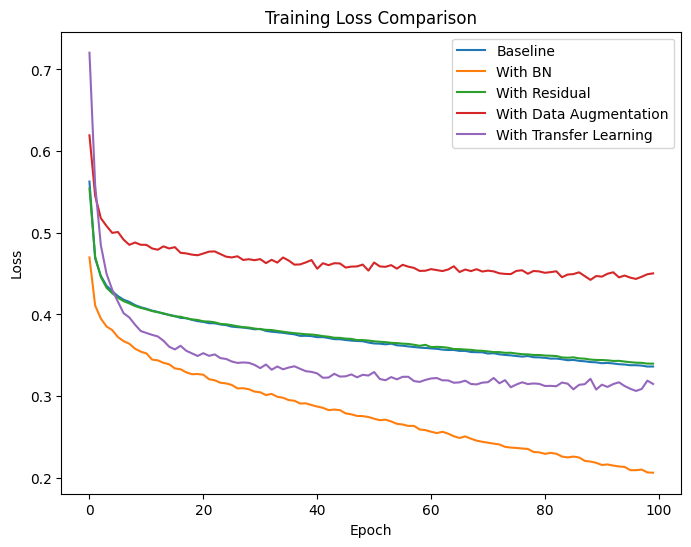

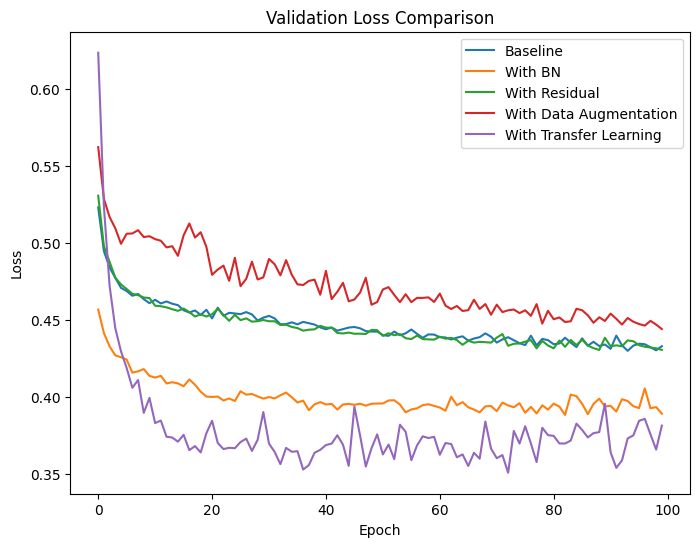

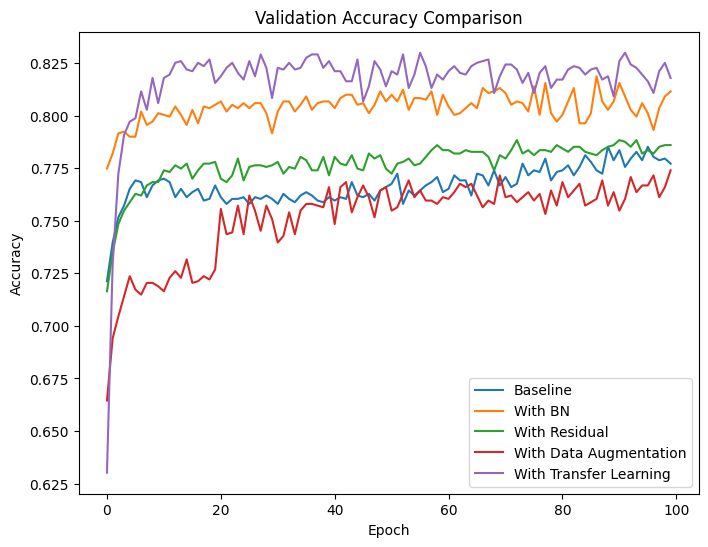

In [16]:
plt.figure(figsize=(8, 6))
for label, data in results.items():
    plt.plot(data['train_loss'], label=label)
plt.title('Training Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
for label, data in results.items():
    plt.plot(data['val_loss'], label=label)
plt.title('Validation Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
for label, data in results.items():
    plt.plot(data['val_accuracy'], label=label)
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [17]:
# Test result using transfer learning

model = model_transfer # best model

model.eval()

correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
     
        images, labels = images.to(device), labels.to(device)
        
        
        outputs = model(images)
        
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'test accuracy: {accuracy:.2f}%')

test accuracy: 81.99%
